# Finding Similar Inputs
Neural network classifiers usually make mistakes on test data. 

<img src="https://drive.google.com/uc?export=download&id=1p5K8QTbYvfcTLvjNIXjna1H3SO1mum5s">

This method may help to explain why an input was misclassified. We will:
- Train a neural network on MNIST images
- Find a few misclassified test inputs
- Answer the question: which are the training examples most similar to the misclassifed input from the point of view of the network?

## Method
Inspired from [Caruana et al (1999)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2232607/).

We will save the activations of one hidden layer for the whole training dataset. Note: in the original paper, they record *all layers*. We picked only one for simplicity and because intuitively a deep layer is more representative than a shallow one.

<img src="https://drive.google.com/uc?export=download&id=1BcnEpgFmQTKC3u7HNyZXe91V3-evflzE">

The activations will look like this:

|                  | Neuron 1 | Neuron 2 | Neuron 3 |   ...    | Neuron n |
| ---------------- | -------- | -------- | -------- | -------- | -------- |
| Training image 1 |    0.5   |   0.7    |   2.1    |   ...    |   -1.1   |
| Training image 2 |    -1.5  |   1.8    |   -3.2   |   ...    |   2.7    |
| Training image 3 |    0.2   |   -0.3   |   1.1    |   ...    |   3.5    |
|       ...        |    ...   |   ...    |   ...    |   ...    |   ...    |
| Training image T |   -1.2   |   1.5    |   0.1    |   ...    |   0.7    |
| Test image       |   0.8    |   0.3    |   0.9    |   ...    |   0.2    |

Then, we will compare the activations of the test image with those, and using k-nearest-neighbors, we'll return the closest images.

> ⚠️ This method relies on unverified assumptions: 
> 1. two inputs are similar from the network's point of view if they have similar activations; 
> 2. comparing activations with euclidean distance is a good idea.
> 
> The method can be used to get a hypothesis, but it will require further verification.

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Number of train images: 60000
Number of test images: 10000
Example training images:


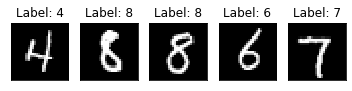

In [1]:
#@title Download dataset
# https://nextjournal.com/gkoehler/pytorch-mnist
!pip install torch torchvision
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

batch_size_train = 64
batch_size_test = 1000

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Download the dataset
train_dataset = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=batch_size_train, shuffle=True)

test_dataset = torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
test_loader = torch.utils.data.DataLoader(
  test_dataset,
  batch_size=batch_size_test, shuffle=True)

print('Number of train images: {}'.format(len(train_dataset)))
print('Number of test images: {}'.format(len(test_dataset)))
print('Example training images:')

fig = plt.figure()
images, labels = next(iter(train_loader))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(images[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(labels[i]))
  plt.xticks([])
  plt.yticks([])

In [2]:
#@title Define the network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=5)
        self.conv2 = nn.Conv2d(5, 2, kernel_size=5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(800, 50)
        self.fc2 = nn.Linear(50, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return self.softmax(x)

network = Net()

In [3]:
#@title Train the network
n_epochs = 2
learning_rate = 0.01
momentum = 0.5
log_interval = 200

optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

loss_func = nn.CrossEntropyLoss()

def train(epoch):
  network.train()
  for batch_idx, (data, label) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = loss_func(output, label)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      # torch.save(network.state_dict(), '/results/model.pth')
      # torch.save(optimizer.state_dict(), '/results/optimizer.pth')

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, label in test_loader:
      output = network(data)
      test_loss += loss_func(output, label).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(label.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


Test set: Avg. loss: 0.0023, Accuracy: 1094/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302211
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.302206
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.296480
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.761723
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.607051

Test set: Avg. loss: 0.0016, Accuracy: 8168/10000 (82%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.567890
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.639172
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.570138
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.704903
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.586292

Test set: Avg. loss: 0.0016, Accuracy: 8375/10000 (84%)



In [4]:
# By default, when given inputs, the model returns only the outputs.
# To record activations in PyTorch, we can use a forward hook, which is a regular Python function. 
# When we attach the hook to a layer, every time that layer is used, our hook will be called.
activations = None # This global variable is used to read the activations after the computations
def hook_fc1(model, input, output):
  global activations
  activations = output.detach() # Only record output of the layer's
network.fc1.register_forward_hook(hook_fc1);

In [5]:
# Record the activations of all training examples
# To avoid the complexity of batching, we load the full training dataset in 1 batch
full_training_dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset))
with torch.no_grad(): # disable gradients to make computations faster
  activations = None
  train_images, train_labels = next(iter(full_training_dataset_loader))
  # Predict for all training images
  train_predictions = network(train_images).data.max(dim=1)[1]
  # Save the activations in a separate variable
  train_activations = activations

  print(train_images.shape, train_labels.shape, train_predictions.shape, train_activations.shape)

torch.Size([60000, 1, 28, 28]) torch.Size([60000]) torch.Size([60000]) torch.Size([60000, 50])


In [6]:
# Record the activations of all test examples
full_test_dataset_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))
with torch.no_grad():
  activations = None
  test_images, test_labels = next(iter(full_test_dataset_loader))
  test_predictions = network(test_images).data.max(dim=1)[1]
  test_activations = activations
  print(test_images.shape, test_labels.shape, test_predictions.shape, test_activations.shape)

torch.Size([10000, 1, 28, 28]) torch.Size([10000]) torch.Size([10000]) torch.Size([10000, 50])


In [11]:
# Find the first 4 images that were misclassified
misclassification_indices = (test_predictions - test_labels).nonzero(as_tuple=True)[0].tolist()
test_indices = misclassification_indices[0:4]

## Finding the closest examples:
The computed activations (for training & test images) are lists of numbers. To find the similarity between two activations, we can use the Euclidean distance.

In 2-dimensions, the Euclidean distance between two points is $d = \sqrt{(x_1 - x_0)^2 + (y_1 - y_0)^2}$

Similarly, in n dimensions we can do the same $d = \sqrt{(x_1 - x_0)^2 + (y_1 - y_0)^2 + (z_1 - z_0)^2 + ...}$

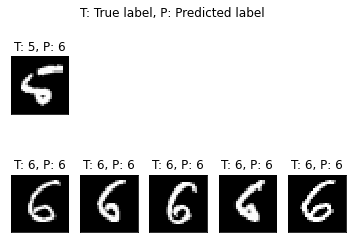

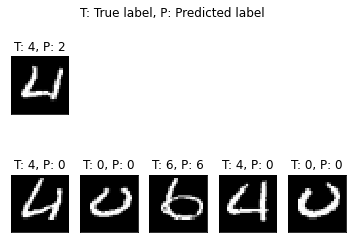

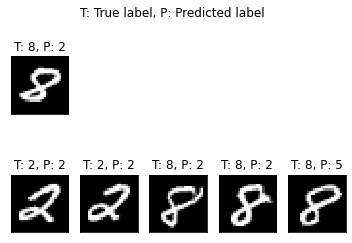

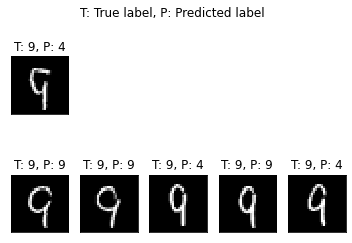

In [14]:
# For the first 4 misclassifications:
for test_idx in test_indices:
  # Find the closest examples
  number_of_examples = 5
  differences = train_activations - test_activations[test_idx:test_idx+1] # Take all train activations and subtract the test image's activation
  distances = torch.norm(differences, dim=1, p=None) # Do the squared sum of all values 
  knn = distances.topk(number_of_examples, largest=False).indices # Get the indices of the smallest distances
  # print('Smallest distances indices: ', knn.tolist())
  # print('Smallest distances: ', distances.index_select(0, knn).tolist())

  # Draw the test image and the most similar training images
  fig = plt.figure()
  fig.suptitle("T: True label, P: Predicted label");
  plt.tight_layout()
  plt.subplot(2,number_of_examples,1)
  plt.imshow(test_images[test_idx][0], cmap='gray', interpolation='none')
  plt.title("T: {}, P: {}".format(test_labels[test_idx], test_predictions[test_idx]))
  plt.xticks([])
  plt.yticks([])
  for i in range(number_of_examples):
    plt.subplot(2,number_of_examples,i+1+number_of_examples)
    plt.imshow(train_images[knn[i]][0], cmap='gray', interpolation='none')
    plt.title("T: {}, P: {}".format(int(train_labels[knn[i]].item()), int(train_predictions[knn[i]].item())))
    plt.xticks([])
    plt.yticks([])

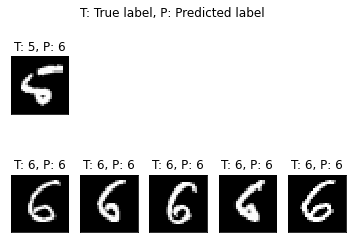

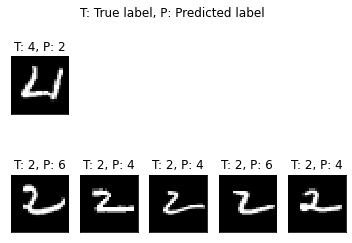

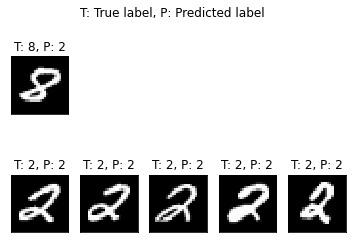

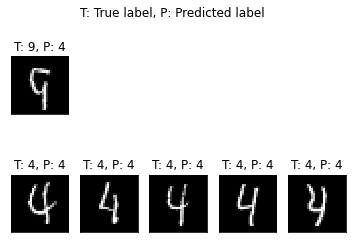

In [16]:
# We can repeat the same procedure, but pick only training images from the test image's predicted label
# (if test image is a 9 but misclassified as a 4, show closest training images from class 4)
for test_idx in test_indices:
  number_of_examples = 5
  train_indices = (train_labels == test_predictions[test_idx]).nonzero(as_tuple=True)[0]

  filtered_train_images = train_images.index_select(0, train_indices)
  filtered_train_labels = train_labels.index_select(0, train_indices)
  filtered_train_activations = train_activations.index_select(0, train_indices)
  filtered_train_predictions = train_predictions.index_select(0, train_indices)

  distances = torch.norm(filtered_train_activations - test_activations[test_idx:test_idx+1], dim=1, p=None)
  knn = distances.topk(number_of_examples, largest=False).indices
  # print('Smallest distances indices: ', knn.tolist())
  # print('Smallest distances: ', distances.index_select(0, knn).tolist())

  fig = plt.figure()
  fig.suptitle("T: True label, P: Predicted label");
  plt.tight_layout()
  plt.subplot(2,number_of_examples,1)
  plt.imshow(test_images[test_idx][0], cmap='gray', interpolation='none')
  plt.title("T: {}, P: {}".format(test_labels[test_idx], test_predictions[test_idx]))
  plt.xticks([])
  plt.yticks([])
  for i in range(number_of_examples):
    plt.subplot(2,number_of_examples,i+1+number_of_examples)
    plt.imshow(filtered_train_images[knn[i]][0], cmap='gray', interpolation='none')
    plt.title("T: {}, P: {}".format(int(filtered_train_labels[knn[i]].item()), int(filtered_train_predictions[knn[i]].item())))
    plt.xticks([])
    plt.yticks([])